# Frequency correlation plots for simulated populations with nested clades

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] <= freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] <= freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
data_root = "../results/builds/simulated/simulated_sample_3/"

In [7]:
first_validation_timepoint = "2023-10-01"

In [8]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [9]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [10]:
tips.head(1)

,strain,timepoint,frequency
8820,sample_4636_1,2023-10-01,0.000013


In [11]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [12]:
tips_to_clades = tips_to_clades.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [13]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [14]:
tips_to_clades.head()

,strain,clade_membership,depth,timepoint
1142111,sample_3560_60,4d834db,0,2023-10-01
1142112,sample_3560_60,80a6fb5,2,2023-10-01
1142113,sample_3552_23,14321ad,0,2023-10-01
1142114,sample_3552_23,4d834db,2,2023-10-01
1142115,sample_3552_23,80a6fb5,3,2023-10-01


In [15]:
tips_to_clades.shape

(3403957, 4)

In [16]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [17]:
forecasts.head(1)

,timepoint,strain,frequency,projected_frequency
0,2016-10-01,sample_3236_14,0.000013,1.405414e-15


In [18]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [19]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [20]:
tips.head()

,strain,timepoint,frequency
8820,sample_4636_1,2023-10-01,0.000013
8821,sample_4636_10,2023-10-01,0.000013
8822,sample_4636_24,2023-10-01,0.000013
8823,sample_4636_27,2023-10-01,0.000013
8824,sample_4636_33,2023-10-01,0.000013


In [21]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["timepoint", "strain"]
)

In [22]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [23]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,sample_4644_80,a9eec25,0,2023-10-01,0.000028,2024-10-01
1,sample_4644_80,0180eca,2,2023-10-01,0.000028,2024-10-01
2,sample_4644_80,da4f798,9,2023-10-01,0.000028,2024-10-01
3,sample_4644_80,dccc328,11,2023-10-01,0.000028,2024-10-01
4,sample_4644_80,6e86842,18,2023-10-01,0.000028,2024-10-01


In [24]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [25]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2023-10-01,2024-10-01,0180eca,0.000739
1,2023-10-01,2024-10-01,022beae,0.014894
2,2023-10-01,2024-10-01,034b162,0.002234
3,2023-10-01,2024-10-01,0886efc,0.014485
4,2023-10-01,2024-10-01,0a65f7a,0.003563


In [26]:
initial_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,future_timepoint,clade_membership,frequency
315,2024-04-01,2025-04-01,cb64469,0.044085
500,2024-10-01,2025-10-01,cb64469,0.405997
705,2025-04-01,2026-04-01,cb64469,0.675714
889,2025-10-01,2026-10-01,cb64469,0.900193
1046,2026-04-01,2027-04-01,cb64469,0.999877
1220,2026-10-01,2027-10-01,cb64469,0.999977
1401,2027-04-01,2028-04-01,cb64469,0.999968
1582,2027-10-01,2028-10-01,cb64469,0.999980
1794,2028-04-01,2029-04-01,cb64469,0.999943
2019,2028-10-01,2029-10-01,cb64469,0.999949


Merge clade frequencies between adjacent years.

In [27]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [28]:
initial_and_observed_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,clade_membership,frequency,frequency_final
60,2024-04-01,cb64469,0.044085,0.675714
93,2024-10-01,cb64469,0.405997,0.900193
121,2025-04-01,cb64469,0.675714,0.999877
144,2025-10-01,cb64469,0.900193,0.999977
171,2026-04-01,cb64469,0.999877,0.999968
205,2026-10-01,cb64469,0.999977,0.999980
249,2027-04-01,cb64469,0.999968,0.999943
291,2027-10-01,cb64469,0.999980,0.999949
341,2028-04-01,cb64469,0.999943,0.999987
386,2028-10-01,cb64469,0.999949,0.999965


Select clades with an initial frequency >15%.

In [29]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > 0.15").copy()

In [30]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2023-10-01,2179bb4,0.981343,0.999948
1,2023-10-01,2b50f0a,0.995828,0.999948
2,2023-10-01,31319fe,0.247704,0.042319
3,2023-10-01,3483876,0.526694,0.042319
4,2023-10-01,3543a7e,0.981256,0.999948


In [31]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
1322,2039-10-01,d91376c,0.548869,0.999954
1324,2039-10-01,f13c38d,0.999977,0.999954
1325,2039-10-01,f1e64ed,0.474601,0.999954
1326,2039-10-01,f7aaa9e,0.999977,0.999954
1327,2039-10-01,fcc72c3,0.999977,0.999954


In [32]:
large_clades.shape

(726, 4)

In [33]:
large_clades["observed_growth_rate"] = (large_clades["frequency_final"] / large_clades["frequency"])

In [34]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
0,2023-10-01,2179bb4,0.981343,0.999948,1.018959
1,2023-10-01,2b50f0a,0.995828,0.999948,1.004137
2,2023-10-01,31319fe,0.247704,0.042319,0.170845
3,2023-10-01,3483876,0.526694,0.042319,0.080348
4,2023-10-01,3543a7e,0.981256,0.999948,1.019049


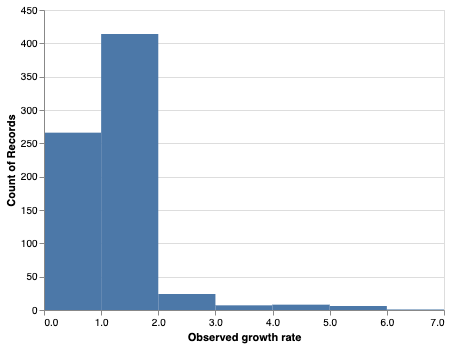

In [35]:
alt.Chart(large_clades).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [36]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["timepoint", "strain"]
)

In [37]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,sample_4644_80,a9eec25,0,2023-10-01,0.000028,0.000004
1,sample_4644_80,0180eca,2,2023-10-01,0.000028,0.000004
2,sample_4644_80,da4f798,9,2023-10-01,0.000028,0.000004
3,sample_4644_80,dccc328,11,2023-10-01,0.000028,0.000004
4,sample_4644_80,6e86842,18,2023-10-01,0.000028,0.000004


In [38]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [39]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2023-10-01,0180eca,0.000373
1,2023-10-01,022beae,0.001168
2,2023-10-01,034b162,0.014724
3,2023-10-01,0886efc,0.002036
4,2023-10-01,0a65f7a,0.000073


In [40]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [41]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [42]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [43]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year
0,2023-10-01,2179bb4,0.981343,0.999948,1.018959,0.995728,1.014658,2023
1,2023-10-01,2b50f0a,0.995828,0.999948,1.004137,0.997764,1.001944,2023
2,2023-10-01,31319fe,0.247704,0.042319,0.170845,0.114071,0.460515,2023
3,2023-10-01,3483876,0.526694,0.042319,0.080348,0.529812,1.005921,2023
4,2023-10-01,3543a7e,0.981256,0.999948,1.019049,0.995727,1.014747,2023


In [44]:
complete_clade_frequencies.shape

(726, 8)

In [45]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [46]:
r

0.6685102488952785

In [47]:
p

3.4618466023233096e-95

In [48]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [49]:
mcc

0.16297469196026246

In [50]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.6590563165905632

In [51]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.6086956521739131

In [52]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [53]:
pseudofrequency = 0.001

In [54]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

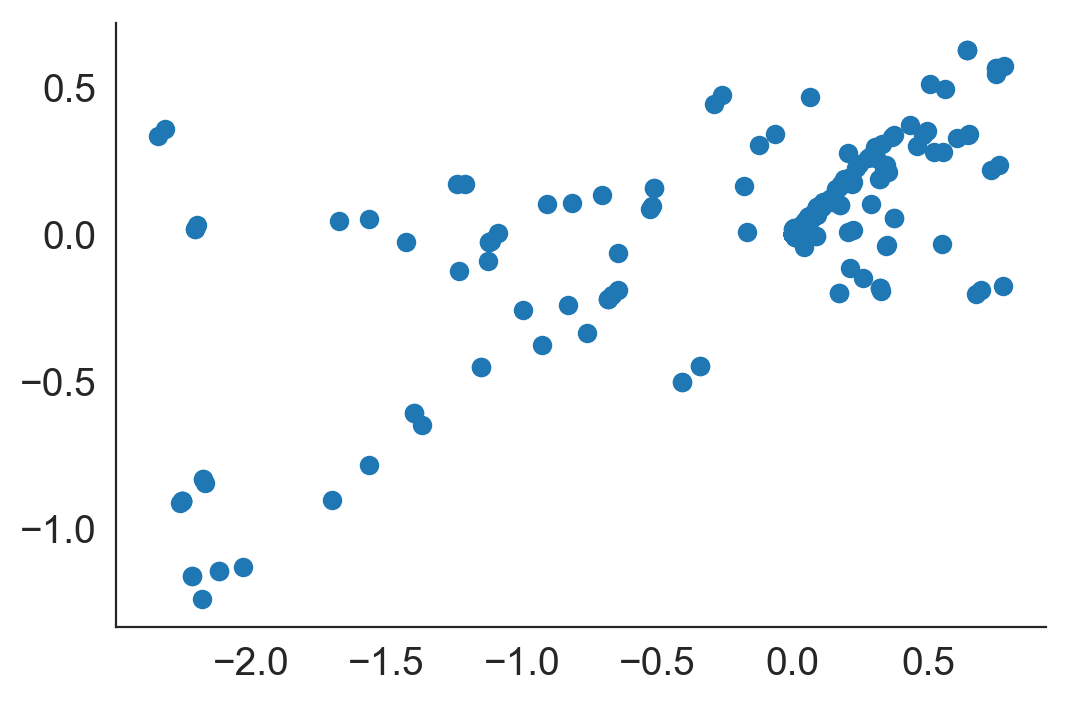

In [55]:
plt.plot(complete_clade_frequencies["log_observed_growth_rate"], complete_clade_frequencies["log_estimated_growth_rate"], "o")

In [56]:
#complete_clade_frequencies["log_observed_growth_rate"] = np.log(complete_clade_frequencies["observed_growth_rate"])
#complete_clade_frequencies["log_estimated_growth_rate"] = np.log(complete_clade_frequencies["estimated_growth_rate"])

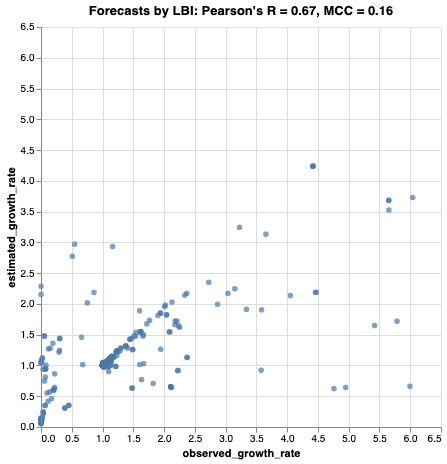

In [57]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

#chart.save("forecast_growth_correlation_natural_lbi.svg")
chart

In [58]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
0,2023-10-01,2179bb4,0.981343,0.999948,1.018959,0.995728,1.014658,2023,0.008148,0.006313
1,2023-10-01,2b50f0a,0.995828,0.999948,1.004137,0.997764,1.001944,2023,0.001791,0.000843
2,2023-10-01,31319fe,0.247704,0.042319,0.170845,0.114071,0.460515,2023,-0.759004,-0.334715
3,2023-10-01,3483876,0.526694,0.042319,0.080348,0.529812,1.005921,2023,-1.085704,0.002559
4,2023-10-01,3543a7e,0.981256,0.999948,1.019049,0.995727,1.014747,2023,0.008187,0.006351


In [59]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

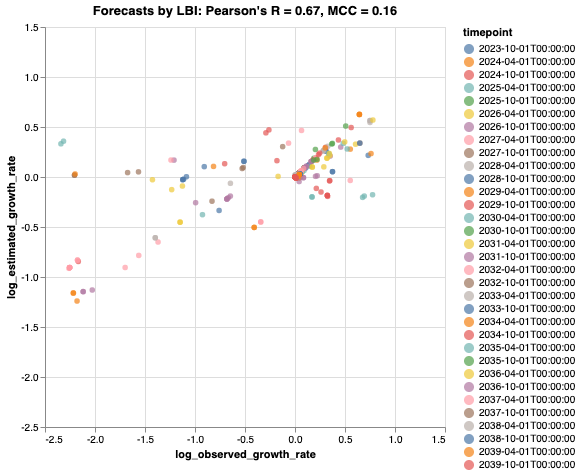

In [60]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [61]:
log_lower_limit

-2.4408594539458464

In [62]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.3408594539458463

In [63]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [64]:
r

0.7130089542062905

In [65]:
p

9.718024697202194e-114

In [66]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.6685102488952785, 3.4618466023233096e-95)

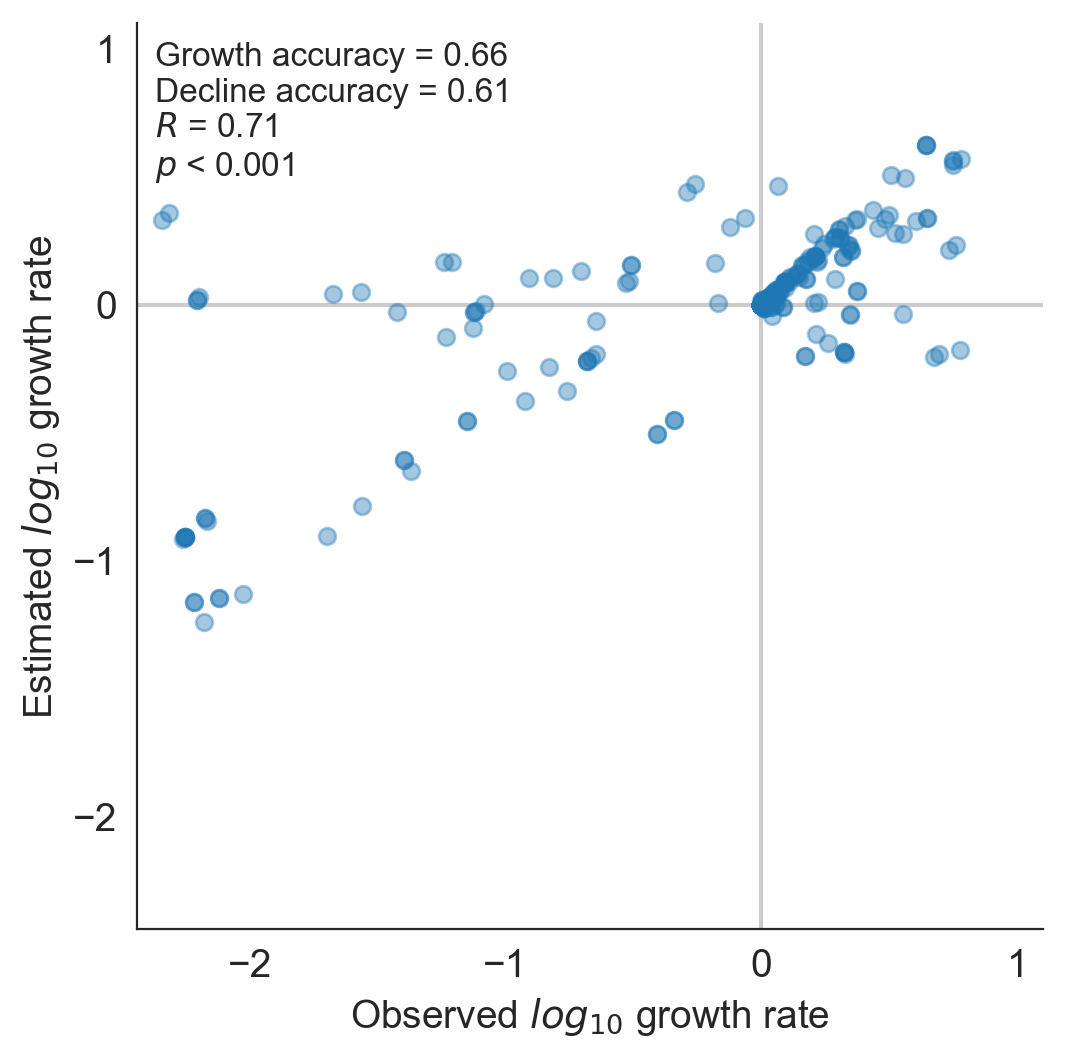

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [68]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [69]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [70]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [71]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.170635
1,2024-04-01,0.688889
2,2024-10-01,0.222222
3,2025-04-01,0.306349
4,2025-10-01,0.039683


Text(0,0.5,'Number of timepoints')

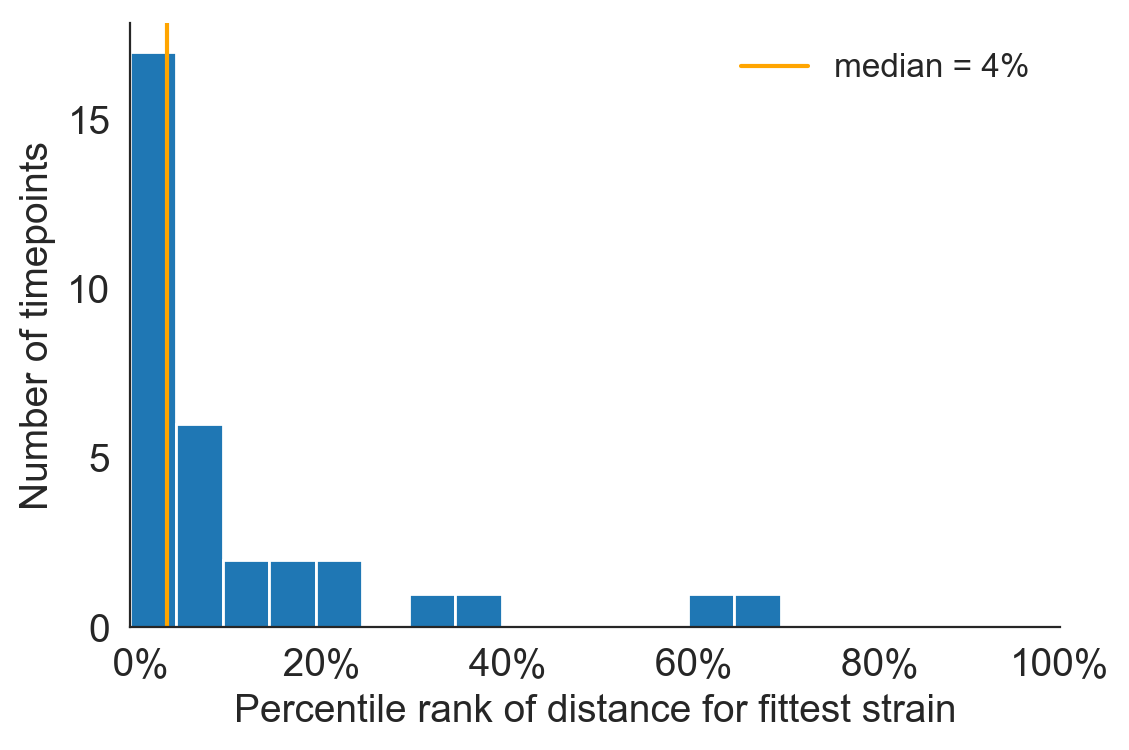

In [72]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

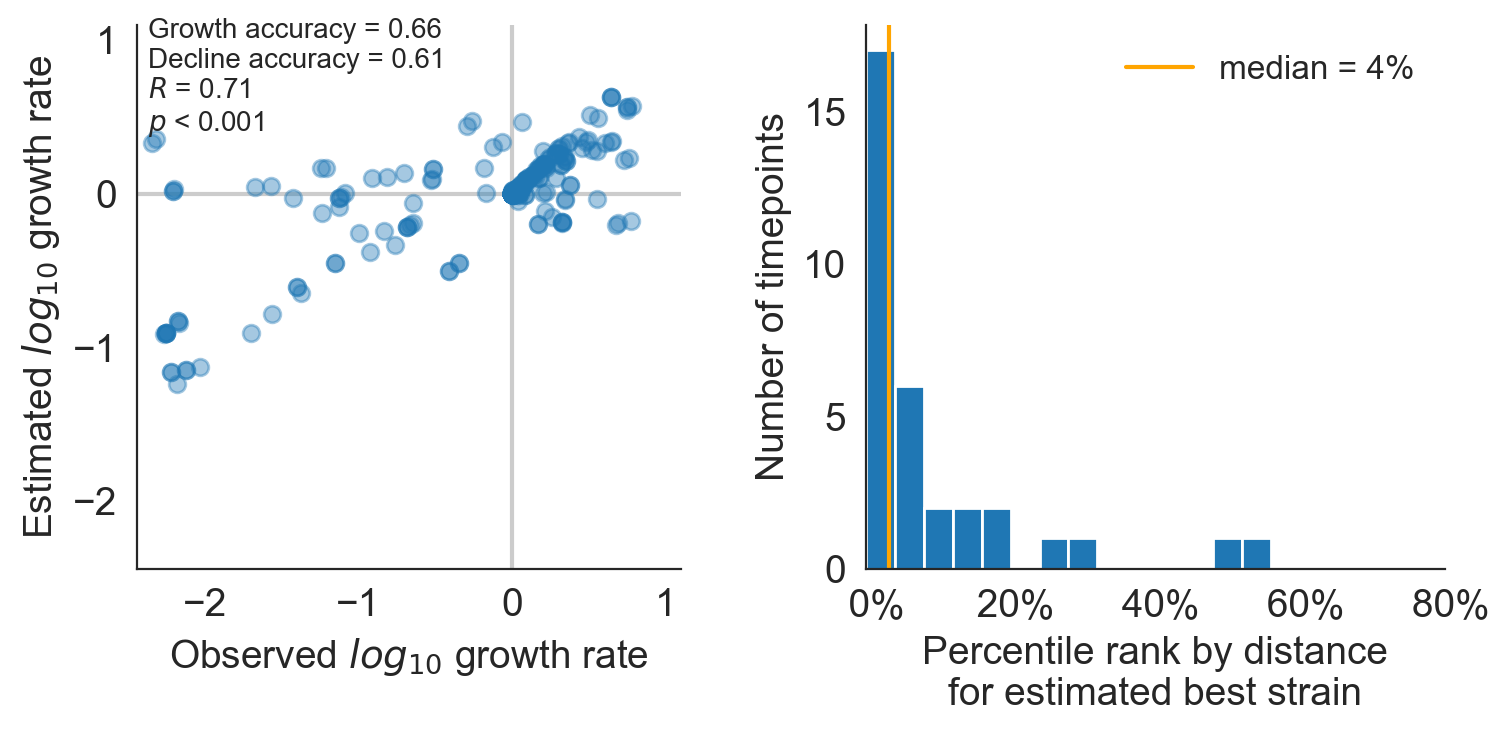

In [73]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")

In [75]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum()

27

In [76]:
best_fitness_rank_by_timepoint_df.shape

(33, 2)

In [77]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.8181818181818182